In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os
import json

# Model And Class Definitions

In [3]:
class ResBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.block = nn.Sequential(nn.GroupNorm(8, ch), nn.SiLU(), nn.Conv2d(ch, ch, 3, padding=1), nn.GroupNorm(8, ch), nn.SiLU(), nn.Conv2d(ch, ch, 3, padding=1))
    def forward(self, x): return x + self.block(x)

class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim, heads=8, dim_head=32):
        super().__init__()
        self.heads, self.dim_head = heads, dim_head
        self.scale = dim_head ** -0.5
        inner_dim = dim_head * heads
        self.to_q, self.to_k, self.to_v = nn.Linear(query_dim, inner_dim, bias=False), nn.Linear(context_dim, inner_dim, bias=False), nn.Linear(context_dim, inner_dim, bias=False)
        self.to_out = nn.Linear(inner_dim, query_dim)
    def forward(self, x, context):
        B, N, C = x.shape
        q, k, v = self.to_q(x), self.to_k(context), self.to_v(context)
        q, k, v = map(lambda t: t.view(B, -1, self.heads, self.dim_head).transpose(1, 2), (q, k, v))
        scores = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(B, N, -1)
        return self.to_out(out)

class CrossAttnUpBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, color_embed_dim):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        self.conv = nn.Sequential(nn.Conv2d(in_ch + skip_ch, out_ch, 3, padding=1), ResBlock(out_ch))
        self.attn = CrossAttention(query_dim=out_ch, context_dim=color_embed_dim)
        self.norm1 = nn.LayerNorm(out_ch)
        self.norm2 = nn.LayerNorm(out_ch) # norm for stability

    def forward(self, x, skip, color_context):
        x = self.up(x); x = torch.cat([x, skip], dim=1); x = self.conv(x)
        B, C, H, W = x.shape
        x_flat = x.view(B, C, -1).permute(0, 2, 1)
        attn_out = self.attn(self.norm1(x_flat), color_context)
        x_flat = self.norm2(x_flat + attn_out) # norm after residual
        x = x_flat.permute(0, 2, 1).view(B, C, H, W)
        return x
class CrossAttnUNet(nn.Module):
    """A 2-Level version of our stable UNet."""
    def __init__(self, in_ch=3, out_ch=3, base_ch=64, color_embed_dim=64):
        super().__init__()
        # encoder
        self.enc1 = nn.Sequential(nn.Conv2d(in_ch, base_ch, 3, padding=1), ResBlock(base_ch))
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(base_ch, base_ch * 2, 3, padding=1), ResBlock(base_ch * 2))
        self.pool2 = nn.MaxPool2d(2)
        self.bot = ResBlock(base_ch * 2)
        # decoder
        self.dec2 = CrossAttnUpBlock(base_ch * 2, base_ch * 2, base_ch, color_embed_dim)
        self.dec1 = CrossAttnUpBlock(base_ch, base_ch, base_ch, color_embed_dim)
        
        self.final_conv = nn.Conv2d(base_ch, out_ch, 1)

    def forward(self, x_outline, color_embedding):
        color_context = color_embedding.unsqueeze(1)
        x1 = self.enc1(x_outline); p1 = self.pool1(x1)
        x2 = self.enc2(p1); p2 = self.pool2(x2)
        b = self.bot(p2)
        d2 = self.dec2(b, x2, color_context)
        d1 = self.dec1(d2, x1, color_context)
        return torch.sigmoid(self.final_conv(d1))

class PolygonColorizer(nn.Module):
    def __init__(self, unet_config, num_colors, embed_dim):
        super().__init__()
        self.color_embedding = nn.Embedding(num_colors, embed_dim)
        self.unet = CrossAttnUNet(**unet_config)
    def forward(self, outline_image, color_id):
        color_embed = self.color_embedding(color_id)
        return self.unet(outline_image, color_embed)
        

COLORS_TO_ID = {
    'red': 0, 'green': 1, 'blue': 2, 'yellow': 3,
    'cyan': 4, 'magenta': 5, 'purple': 6, 'orange': 7
}

class PolygonDataset(Dataset):
    def __init__(self, root_dir, split, img_size):
        self.img_size = img_size
        base_path = os.path.join(root_dir, split)
        json_path = os.path.join(base_path, 'data.json')
        self.COLORS_TO_ID = COLORS_TO_ID
        with open(json_path) as f: self.items = json.load(f)
        self.base_path = base_path
        self.transform = transforms.Compose([transforms.Resize((self.img_size, self.img_size)), transforms.ToTensor()])
    def __len__(self): return len(self.items)
    def __getitem__(self, idx):
        item = self.items[idx]
        img_in = Image.open(os.path.join(self.base_path, 'inputs', item['input_polygon'])).convert('RGB')
        img_out = Image.open(os.path.join(self.base_path, 'outputs', item['output_image'])).convert('RGB')
        x_outline_rgb, y_rgb = self.transform(img_in), self.transform(img_out)
        color_name = item['colour']
        color_id = torch.tensor(self.COLORS_TO_ID.get(color_name, 7), dtype=torch.long)
        return x_outline_rgb, y_rgb, color_id

print("Model and Dataset classes are defined.")


Model and Dataset classes are defined.


# Inference

### Defining the dataset path

In [4]:
DATASET_PATH = '/kaggle/input/polygon-coloring/dataset'

Model weights loaded successfully from Hugging Face Hub.


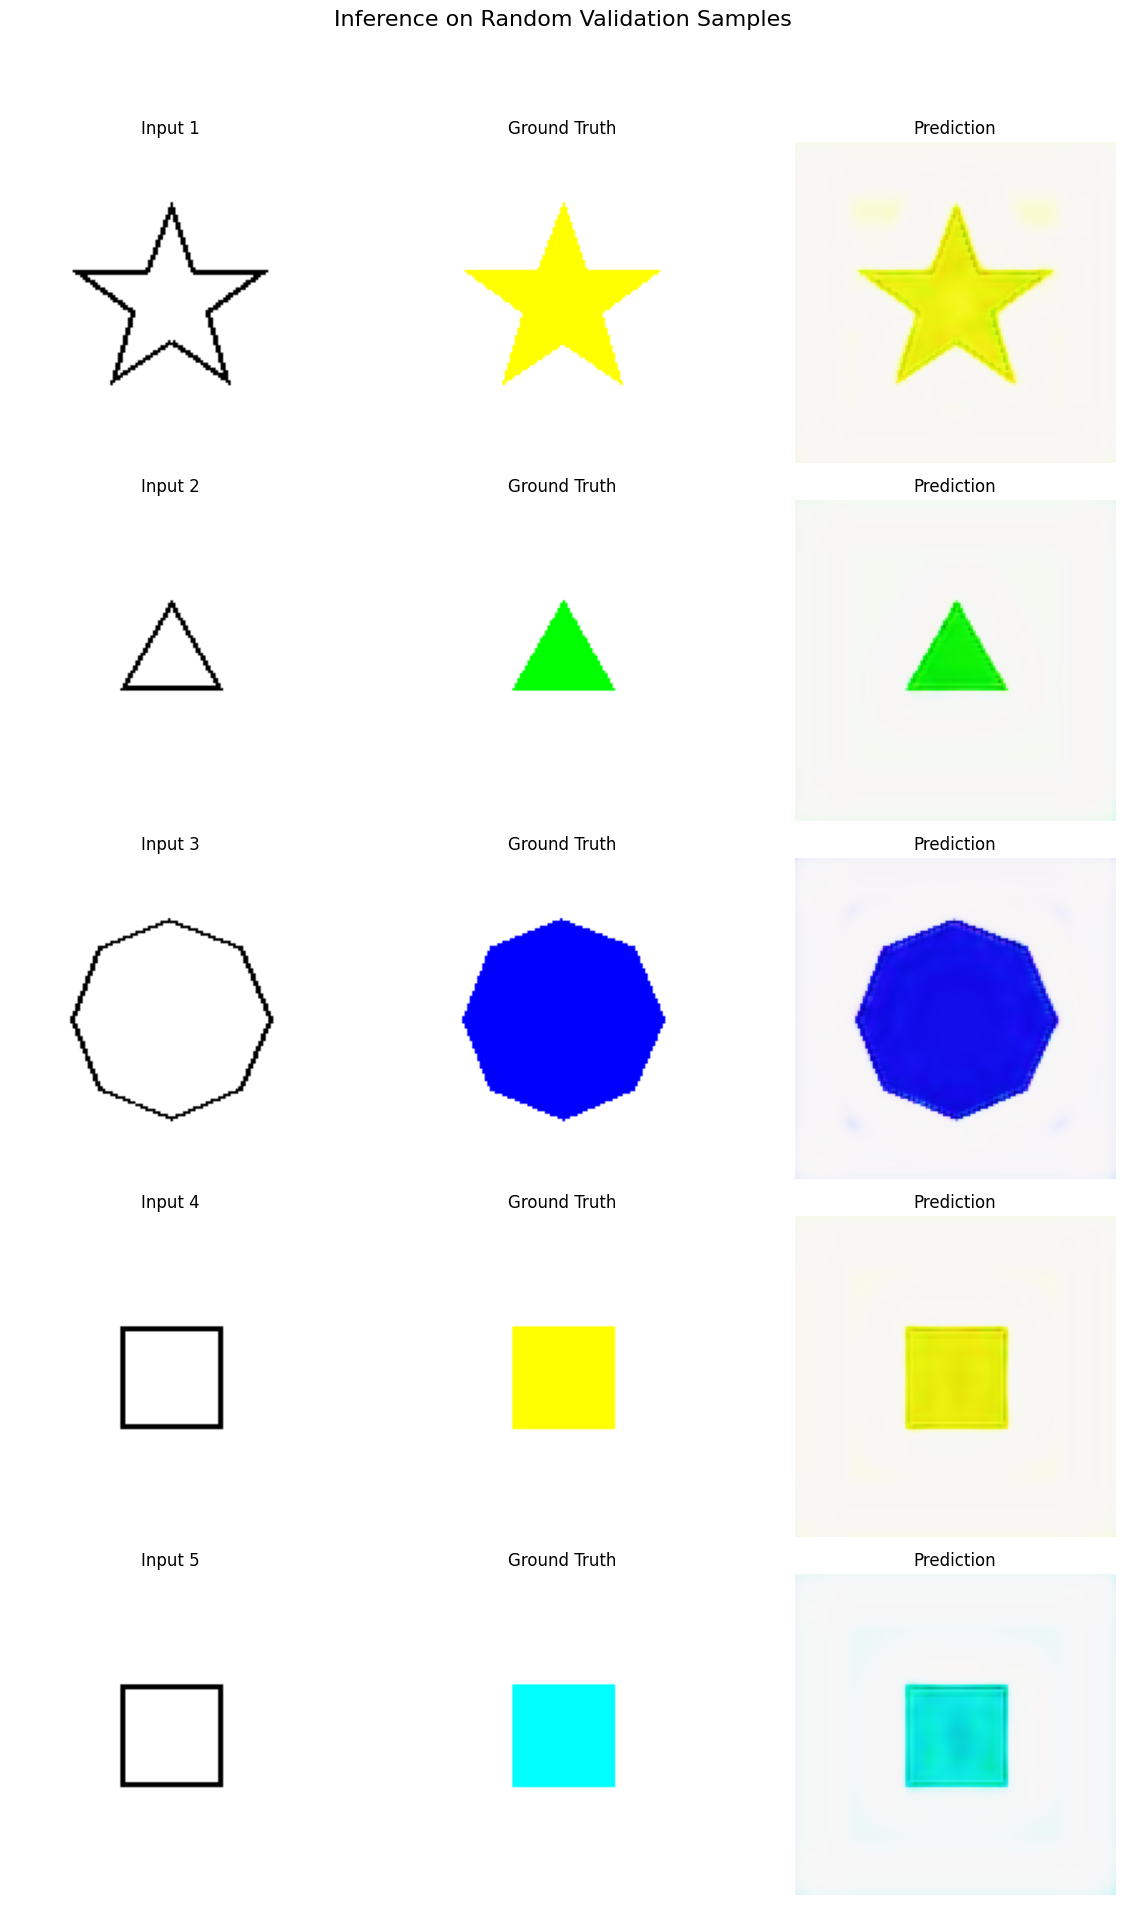

In [8]:
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
import numpy as np

REPO_ID = "parvpareek/polygon-colorizer-unet" 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

UNET_CONFIG = {'in_ch': 3, 'out_ch': 3, 'base_ch': 64, 'color_embed_dim': 32}
NUM_COLORS = 8
EMBED_DIM = 32

inference_model = PolygonColorizer(
    unet_config=UNET_CONFIG,
    num_colors=NUM_COLORS,
    embed_dim=EMBED_DIM
).to(DEVICE)

try:
    weights_path = hf_hub_download(repo_id=REPO_ID, filename="pytorch_model.bin")
    inference_model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
    print("Model weights loaded successfully from Hugging Face Hub.")
except Exception as e:
    print(f"Error loading model weights: {e}")


DATASET_PATH = '/kaggle/input/polygon-coloring/dataset'
val_dataset = PolygonDataset(root_dir=DATASET_PATH, split='validation', img_size=128)


def visualize_predictions(model, dataset, device, num_samples=5):
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples * 4))
    fig.suptitle("Inference on Random Validation Samples", fontsize=16)

    with torch.no_grad():
        for i in range(num_samples):
            x_outline, y_rgb, color_id = dataset[i]
            
            # Prepare tensors for the model
            input_tensor = x_outline.unsqueeze(0).to(device)
            color_id_tensor = color_id.unsqueeze(0).to(device)
            
            # Run inference
            predicted_image = model(input_tensor, color_id_tensor).squeeze(0).cpu()
            
            # Prepare for plotting
            input_display = x_outline.permute(1, 2, 0).numpy()
            gt_display = y_rgb.permute(1, 2, 0).numpy()
            pred_display = predicted_image.permute(1, 2, 0).numpy()

            # Plotting
            axes[i, 0].imshow(input_display); axes[i, 0].set_title(f"Input {i+1}"); axes[i, 0].axis('off')
            axes[i, 1].imshow(gt_display); axes[i, 1].set_title("Ground Truth"); axes[i, 1].axis('off')
            axes[i, 2].imshow(pred_display); axes[i, 2].set_title("Prediction"); axes[i, 2].axis('off')
            
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

visualize_predictions(inference_model, val_dataset, DEVICE, num_samples=5)